In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw6/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 235 (delta 107), reused 212 (delta 90), pack-reused 0
Receiving objects: 100% (235/235), 30.54 MiB | 17.83 MiB/s, done.
Resolving deltas: 100% (107/107), done.
--2021-12-07 14:59:09--  https://docs.google.com/uc?export=download&confirm=pJy0&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 173.194.76.139, 173.194.76.102, 173.194.76.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-0o-docs.googleusercontent.com/docs/securesc/j6ftmv61vupvb2pnk8ppq1ov6g9e14fk/28oj1ov4u95l9jon3m9srg57fgkb078e/1638889125000/06419056966375271799/15009299865881527688Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-12-07 14:59:09--  https://doc-14-0o-docs.go

In [ ]:
from dul_2021.utils.hw6_utils import *

# Question 1: VAEs on Images
In this question, you will train VAE model on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

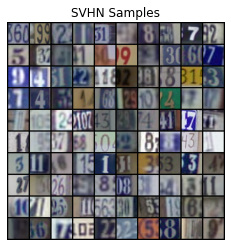

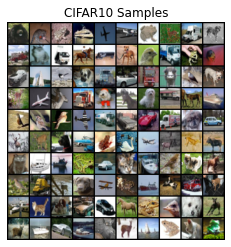

In [ ]:
visualize_svhn()
visualize_cifar10()

## VAE with AF Prior
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as in homework 5. For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
from typing import Set, List, Dict, Any, Optional, Tuple
from tqdm import tqdm, trange

from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
import torch
import torch.nn as nn
import torch.optim as optim 

import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


"Encoder" and "Decoder" implementation from VAE. 

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),  # -> 32 x 32 x 32
            nn.ReLU(), 
            nn.Conv2d(32, 64, 3, 2, 1),  # -> 64 x 16 x 16
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1),  # -> 128 x 8 x 8
            nn.ReLU(), 
            nn.Conv2d(128, 256, 3, 2, 1),  # -> 256 x 4 x 4
            nn.ReLU(), 
            nn.Flatten(), 
            nn.Linear(4 * 4 * 256, 2 * latent_dim)) 

    def forward(self, xs: torch.Tensor) -> torch.Tensor: 
        return self.model(xs.float())


class Decoder(nn.Module): 
    def __init__(self, latent_dim: int): 
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128), 
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, 2, 1),  # -> 128 x 8 x 8 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # -> 64 x 16 x 16
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # -> 32 x 32 x 32
            nn.ReLU(), 
            nn.Conv2d(32, 3, 3, 1, 1))  # -> 3 x 32 x 32

    def forward(self, zs: torch.Tensor) -> torch.Tensor: 
        out = self.layer1(zs.float())
        out = out.view(len(zs), 128, 4, 4)
        out = self.layer2(out)
        return out

MADE imlementation from Homework 1. 

In [ ]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_dim: int, out_dim: int, bias: bool = True):
        super().__init__(in_dim, out_dim, bias)        
        self.register_buffer("mask", torch.ones(out_dim, in_dim))
        
    def set_mask(self, mask: np.ndarray):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, input_dim: int, d: int, h_sizes: List[int]): 
        super().__init__()
        self.d = d
        self.in_dim = input_dim
        self.out_dim = input_dim * d
        self.h_sizes = h_sizes 
        self.network = nn.Sequential(*self.make_network())

    def make_network(self) -> List[nn.Module]:
        network = []
        hs = [self.in_dim] + self.h_sizes + [self.out_dim]

        for n_in, n_out in zip(hs, hs[1:]): 
            network.extend([MaskedLinear(n_in, n_out), nn.ReLU()])
            
        network.pop()  # nn.ReLU()
        return network

    def make_masks(self):
        m = {}
        L = len(self.h_sizes)
        m[-1] = np.arange(self.in_dim)
        for l in range(L):
            m[l] = np.random.randint(m[l - 1].min(), 
                                     self.in_dim - 1, 
                                     size=self.h_sizes[l])
        
        masks = [m[l - 1][:, None] <= m[l][None, :] for l in range(L)]
        masks.append(m[L - 1][:, None] < m[-1][None, :])
        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        layers = [l for l in self.network.modules() if isinstance(l, MaskedLinear)]
        for layer, mask in zip(layers, masks):
            layer.set_mask(mask)

    def forward(self, xs: torch.Tensor) -> torch.Tensor:
        out = xs.view(len(xs), self.in_dim)
        out = self.network(xs)
        out = out.view(len(xs), self.in_dim, self.d)
        return out

In [ ]:
class VLAE(nn.Module): 
    def __init__(self, latent_dim: int): 
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

        self.made = MADE(latent_dim, 2, [512, 512])

        self.p_z = Normal(torch.tensor(0, dtype=torch.float32, device=device), 
                          torch.tensor(1, dtype=torch.float32, device=device))
        
    def encode(self, xs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]: 
        encoded = self.encoder(xs)  # batch_size x (2 * latent_dim)
        mu, log_s = encoded.split(self.latent_dim, dim=1)
        return mu, log_s

    def decode(self, zs: torch.Tensor) -> torch.Tensor: 
        return self.decoder(zs)
        
    def loss(self, xs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]: 
        # xs.shape = (batch_size, 3, 32, 32), in [-1., 1.]
        mu_z, log_std_z = self.encode(xs)
        z = self.p_z.sample(mu_z.shape) * log_std_z.exp() + mu_z  # -> batch_size x latent_dim
        x_recon = self.decode(z)  # -> batch_size x 3 x 32 x 32

        recon_loss = F.mse_loss(x_recon, xs, reduction="none").view(len(xs), -1).sum(1).mean()
        enc_log_prob = -0.5 * np.log(2 * np.pi) - log_std_z - 0.5 * (z - mu_z) ** 2 * torch.exp(-2 * log_std_z)

        made_out = self.made(z)  # -> batch_size x latent_dim x 2
        mu, log_std = made_out.chunk(2, dim=-1)  # -> batch_size x latent_dim x 1
        mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)  # -> batch_size x latent_dim
        log_std = torch.tanh(log_std)
        eps = z * log_std.exp() + mu  # -> batch_size x latent_dim
        prior_log_prob = -0.5 * np.log(2 * np.pi) + log_std - 0.5 * eps ** 2

        kld_loss = (enc_log_prob - prior_log_prob).sum(1).mean()
        return recon_loss, kld_loss

    def sample(self, n_samples: int) -> np.ndarray: 
        self.eval()

        with torch.no_grad(): 
            z = self.p_z.sample((n_samples, self.latent_dim))
            for i in range(self.latent_dim): 
                mu, log_std = self.made(z)[:, i].chunk(2, dim=-1)  
                mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)  # -> n_samples x 1
                log_std = torch.tanh(log_std)
                z[:, i] = (z[:, i] - mu) * torch.exp(-log_std)
        return self.decode(z).cpu().detach().numpy()

    def reconstruct(self, data: np.ndarray) -> np.ndarray: 
        self.eval()

        data = collate_fn(data)

        with torch.no_grad(): 
            mu_z, _ = self.encode(data)
            recons = self.decode(mu_z)
            recon = torch.clip(recons, -1, 1)

        return recons.cpu().detach().numpy()

    def interpolate(self, data: List[Tuple[np.ndarray, np.ndarray]]) -> np.ndarray: 
        self.eval() 

        interpolations = np.zeros((len(data), 10, 3, 32, 32))

        with torch.no_grad(): 
            for i, (img_1, img_2) in enumerate(data): 
                img_1, img_2 = collate_fn([img_1]), collate_fn([img_2])

                mu_1, _ = self.encode(img_1)
                mu_2, _ = self.encode(img_2)

                for j in range(0, 10):
                    alpha = j / 9

                    z = mu_1 * (1 - alpha) + mu_2 * alpha
                    recon = torch.clip(self.decode(z), -1, 1)

                    interpolations[i, j] = recon.cpu().detach().numpy()

        return interpolations.reshape(len(data) * 10, 3, 32, 32)

In [ ]:
def collate_fn(x: np.ndarray) -> torch.Tensor: 
    x = torch.tensor(x, dtype=torch.float32, device=device)
    return x

def train_epochs(model: nn.Module, train_data: np.ndarray, test_data: np.ndarray, 
                 epochs: int = 100, lr: float = 1e-3, batch_size: int = 128) -> Tuple[np.ndarray, np.ndarray]:
    model = model.to(device)
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                             shuffle=False, collate_fn=collate_fn)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = [test_epoch(model, test_loader)]

    for _ in trange(epochs): 
        train_losses.extend(train_epoch(model, train_loader, optimizer))
        test_losses.append(test_epoch(model, test_loader))

    return np.array(train_losses), np.array(test_losses)
        

def train_epoch(model, data_loader, optimizer) -> List[List[float]]: 
    model.train()

    losses = []
    for batch in data_loader: 
        recon_loss, kld_loss = model.loss(batch)
        loss = recon_loss + kld_loss 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        losses.append([loss.item(), recon_loss.item(), -kld_loss.item()])
    
    return losses

def test_epoch(model, data_loader) -> List[float]: 
    model.eval()

    total_loss = total_kl = total_rec_loss = 0

    with torch.no_grad(): 
        for batch in data_loader: 
            recon_loss, kld_loss = model.loss(batch)
            loss = recon_loss + kld_loss

            total_loss += loss.item()
            total_kl += -kld_loss.item()
            total_rec_loss += recon_loss.item()

    n_iters = len(data_loader)
    return [total_loss / n_iters,  total_rec_loss / n_iters, total_kl / n_iters]

In [ ]:
def transform_images(images: np.ndarray) -> np.ndarray: 
    images = images.transpose(0, 3, 1, 2) / 255.
    images = 2 * images - 1
    return images

def inv_transform_images(images: np.ndarray) -> np.ndarray: 
    images = 0.5 * images + 0.5
    images = images.transpose(0, 2, 3, 1) * 255. 
    return images

In [ ]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    train_data_normed = transform_images(train_data)
    test_data_normed = transform_images(test_data)

    model = VLAE(latent_dim=16)
    train_losses, test_losses = train_epochs(model, train_data_normed, test_data_normed, 
                                             epochs=100)
    samples = inv_transform_images(model.sample(100))

    out = inv_transform_images(model.reconstruct(test_data_normed[:50]))
    recons = np.zeros((100, 32, 32, 3))
    for i in range(50): 
        recons[2 * i] = test_data[i]
        recons[2 * i + 1] = out[i]

    pairs = []
    for i in range(10): 
        pairs.append((test_data_normed[2 * i], test_data_normed[2 * i + 1]))
    inters = inv_transform_images(model.interpolate(pairs))

    return train_losses, test_losses, samples, recons, inters

### Results
Once you've finished `q1`, execute the cells below to visualize and save your results.

100%|██████████| 100/100 [23:00<00:00, 13.81s/it]


Final -ELBO: 54.9725, Recon Loss: 87.5630, KL Loss: 32.5905


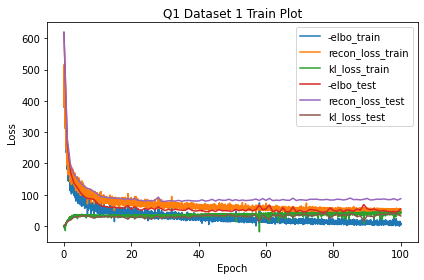

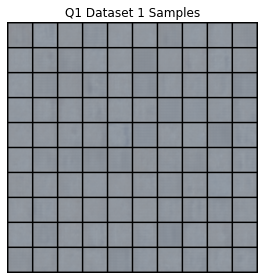

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


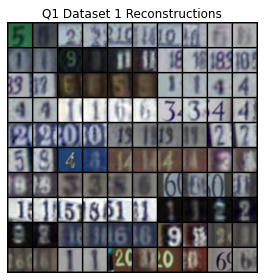

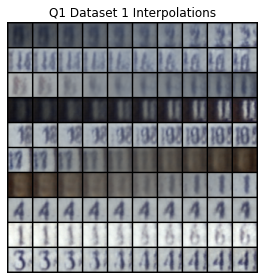

In [ ]:
q1_save_results(1, q1)

Final -ELBO: 102.5659, Recon Loss: 80.2548, KL Loss: 22.3111


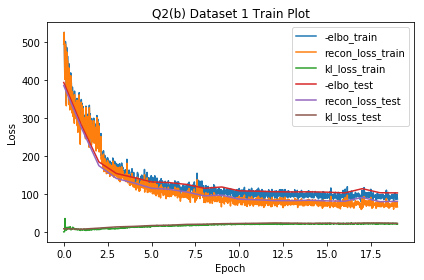

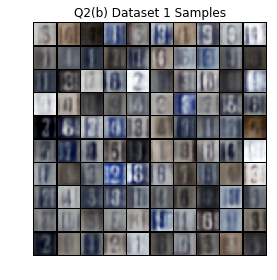

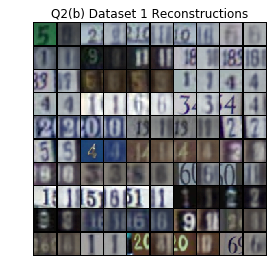

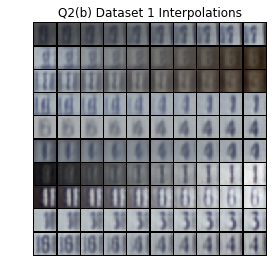

In [ ]:
q1_save_results(1, q1)

In [ ]:
q1_save_results(2, q1)

# Question 2: VQ-VAE
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q2`, execute the cells below to visualize and save your results.

VQ-VAE Final Test Loss: 0.0286
PixelCNN Prior Final Test Loss: 1.9440


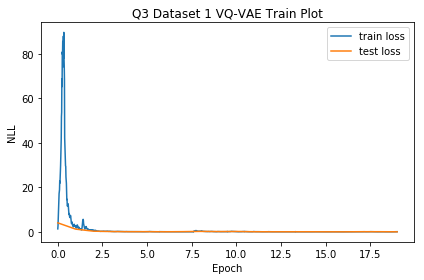

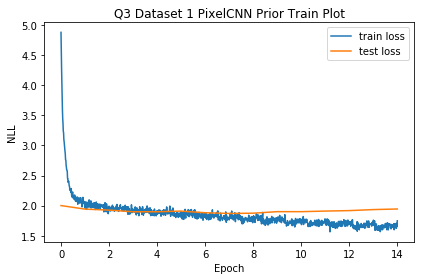

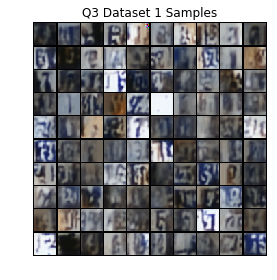

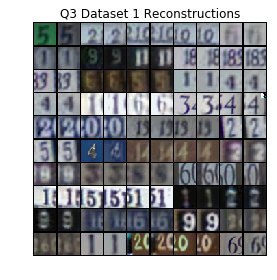

In [ ]:
q2_save_results(1, q2)

In [ ]:
q2_save_results(2, q2)

# Bonus 4

## Part (a) Improving VQ-VAE Results
Improve upon your results in Q2, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `b4_a`, execute the cells below to visualize and save your results.

In [ ]:
b4_a_save_results(2, b4_a)

## Part (b) PixelVAE
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def b4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `b4_b`, execute the cells below to visualize and save your results

In [ ]:
b4_b_save_results(b4_b)